# SHAP explanations

In this notebook we use SHAP to **explain the predictions of a NN model**.

<script type="text/javascript" async
  src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
</script>

Interpretability is important in many fields. With SHAP we can decompose the value of a prediction $f(x)$ into components, assigning them each of the features $x_i$.

SHAP is a great tool because **it is model agnostic**. It doesn't require a closed-form description of your model, but only being able to call/evaluate it at different locations!

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore", category=ConvergenceWarning)

/Users/emiliomaddalena/Documents/github/causal-inference-studies/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate synthetic data

In [7]:
np.random.seed(42)
n_samples = 1000

X1 = np.random.uniform(0, 10, n_samples)
X2 = np.random.uniform(0, 10, n_samples)
X3 = np.random.uniform(0, 10, n_samples)


# Define the target with a non-linear relationship
def f(X1, X2, X3):
    return 5 * X1**2 - 10 * X2 + 5 * X3

Y = f(X1, X2, X3) + np.random.normal(0, 2, n_samples)
X = pd.DataFrame({"X1": X1, "X2": X2, "X3": X3})

### Train a simple NN regressor

Epoch 5000, Training MSE: 16.7202
Epoch 10000, Training MSE: 13.3218


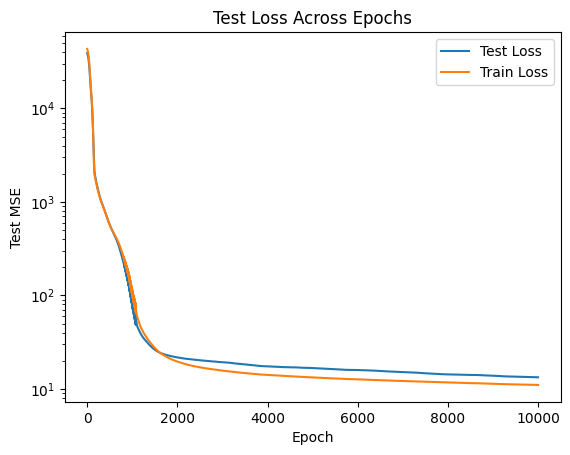

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

mlp = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    max_iter=1,
    warm_start=True,
    random_state=42,
)
n_epochs = 10000

test_losses = []
train_losses = []
for epoch in range(n_epochs):
    mlp.fit(X_train, y_train)
    train_losses.append(mean_squared_error(y_train, mlp.predict(X_train)))
    test_losses.append(mean_squared_error(y_test, mlp.predict(X_test)))
    if (epoch + 1) % 5000 == 0:
        print(f"Epoch {epoch+1}, Training MSE: {test_losses[-1]:.4f}")

plt.plot(test_losses, label="Test Loss")
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test MSE")
plt.title("Test Loss Across Epochs")
plt.yscale("log")
plt.show()

### Assess performance on the test set

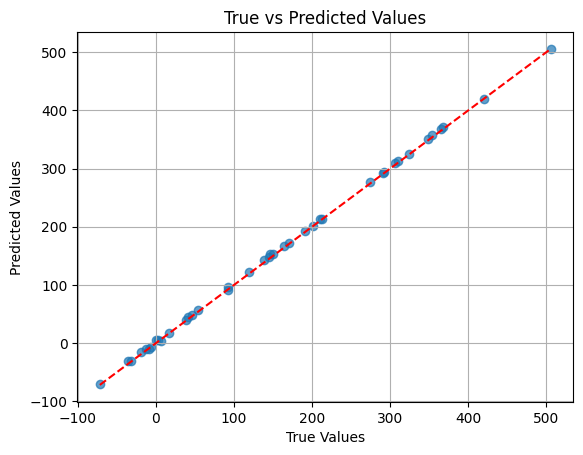

In [9]:
idxs = np.random.choice(len(X_test), size=40, replace=False)
X_sample = X_test.iloc[idxs]
y_true = f(X_sample["X1"], X_sample["X2"], X_sample["X3"])
y_pred = mlp.predict(X_sample)

#plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.grid()

### Explain the model with SHAP

In [10]:
# Create a SHAP explainer
explainer = shap.Explainer(mlp.predict, X)
shap_values = explainer(X)

[6.11852895 6.97420267 9.63394434]


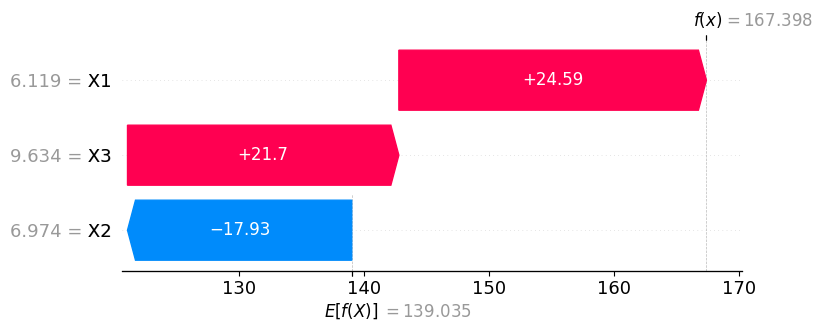

In [11]:
# Explain the output number 20
i = 20
print(shap_values[i].data)
shap.plots.waterfall(shap_values[i])

shap.initjs()
shap.force_plot(shap_values.base_values[i], shap_values.values[i], feature_names=['X1', 'X2', 'X3'])

/var/folders/pt/2bxzkxcx2199r7zn3rhd3qt40000gn/T/ipykernel_26835/3448107941.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


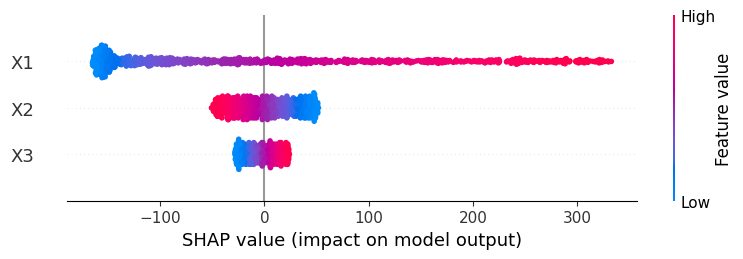

In [12]:
# Explain all of the examples
shap.summary_plot(shap_values, X)

### Conclusions

<script type="text/javascript" async
  src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
</script>

SHAP is very cool, but what exactly can we conclude from its outputs?

It sheds some light on which features are more important than others from a high-level perspective - that's for sure. $x_1$ seems to have a larger impact on the predictions compared to $x_2$ or $x_3$...

⚠️ Question: **Can we interpret these insights causally?**

🚫 Answer: **No, we can't!**

If the model wasn't built in a causal way, it is still confounded, no matter what type of explainability tool you throw at it...